In [43]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 20)

In [2]:
data = pd.read_csv("wiki_links.csv")

In [3]:
data.shape

(164470, 2)

In [7]:
data.tail(1).values

array([['https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Norway',
        'https://en.wikipedia.org/wiki/Category:Project_pages_with_short_description']],
      dtype=object)

### extracting titles from the links

In [9]:
data['source title'] = data['source'].apply(lambda x: str(x).\
                                            replace(':','/').split('/')[-1].replace('_',' '))
data['destination title'] = data['destination'].apply(lambda x: str(x).\
                                            replace(':','/').split('/')[-1].replace('_',' '))

In [11]:
df = data.drop(['source', 'destination'], axis=1)

In [12]:
df.head()

,source title,destination title
0,Earl of Dysart,Earl of Desart
1,Earl of Dysart,Earl of Dysart COA.svg
2,Earl of Dysart,Charles I of England
3,Earl of Dysart,Peerage of Scotland
4,Earl of Dysart,"William Murray, 1st Earl of Dysart"


In [15]:
len(df['source title'].unique())

541

In [16]:
len(df['destination title'].unique())

87110

In [17]:
sources = list(df['source title'].unique())

In [18]:
df['keep'] = df['destination title'].apply(lambda x: True if x in sources else False)

In [20]:
df = df[df['keep']==True].drop('keep',axis=1)

In [21]:
df.head()

,source title,destination title
0,Earl of Dysart,Earl of Desart
1,Earl of Dysart,Earl of Dysart COA.svg
2,Earl of Dysart,Charles I of England
3,Earl of Dysart,Peerage of Scotland
4,Earl of Dysart,"William Murray, 1st Earl of Dysart"


In [22]:
df.shape

(6969, 2)

In [23]:
len(df)

6969

In [24]:
from sklearn import preprocessing

In [25]:
se = preprocessing.LabelEncoder()
se.fit(df['source title'])
df['source label'] = se.transform(df['source title'])

In [26]:
de = preprocessing.LabelEncoder()
de.fit(df['destination title'])
df['destination label'] = de.transform(df['destination title'])

In [27]:
df.head()

,source title,destination title,source label,destination label
0,Earl of Dysart,Earl of Desart,159,158
1,Earl of Dysart,Earl of Dysart COA.svg,159,160
2,Earl of Dysart,Charles I of England,159,110
3,Earl of Dysart,Peerage of Scotland,159,341
4,Earl of Dysart,"William Murray, 1st Earl of Dysart",159,526


In [28]:
df.tail()

,source title,destination title,source label,destination label
164396,WikiProject Norway,WikiProject Council,509,503
164397,WikiProject Norway,WikiProject,509,499
164403,WikiProject Norway,WikiProject report,509,512
164459,WikiProject Norway,Wikipedia,509,519
164467,WikiProject Norway,WikiProject Norway,509,509


In [29]:
n_df = df.drop(['source title', 'destination title'], axis=1)

In [31]:
records = list(n_df.to_records(index=False))
records = [i for i in records if i[0]!=i[1]]

In [33]:
G = nx.Graph()

In [34]:
G.add_edges_from(records)

In [36]:
G.number_of_nodes()

541

In [37]:
G.number_of_edges()

4875

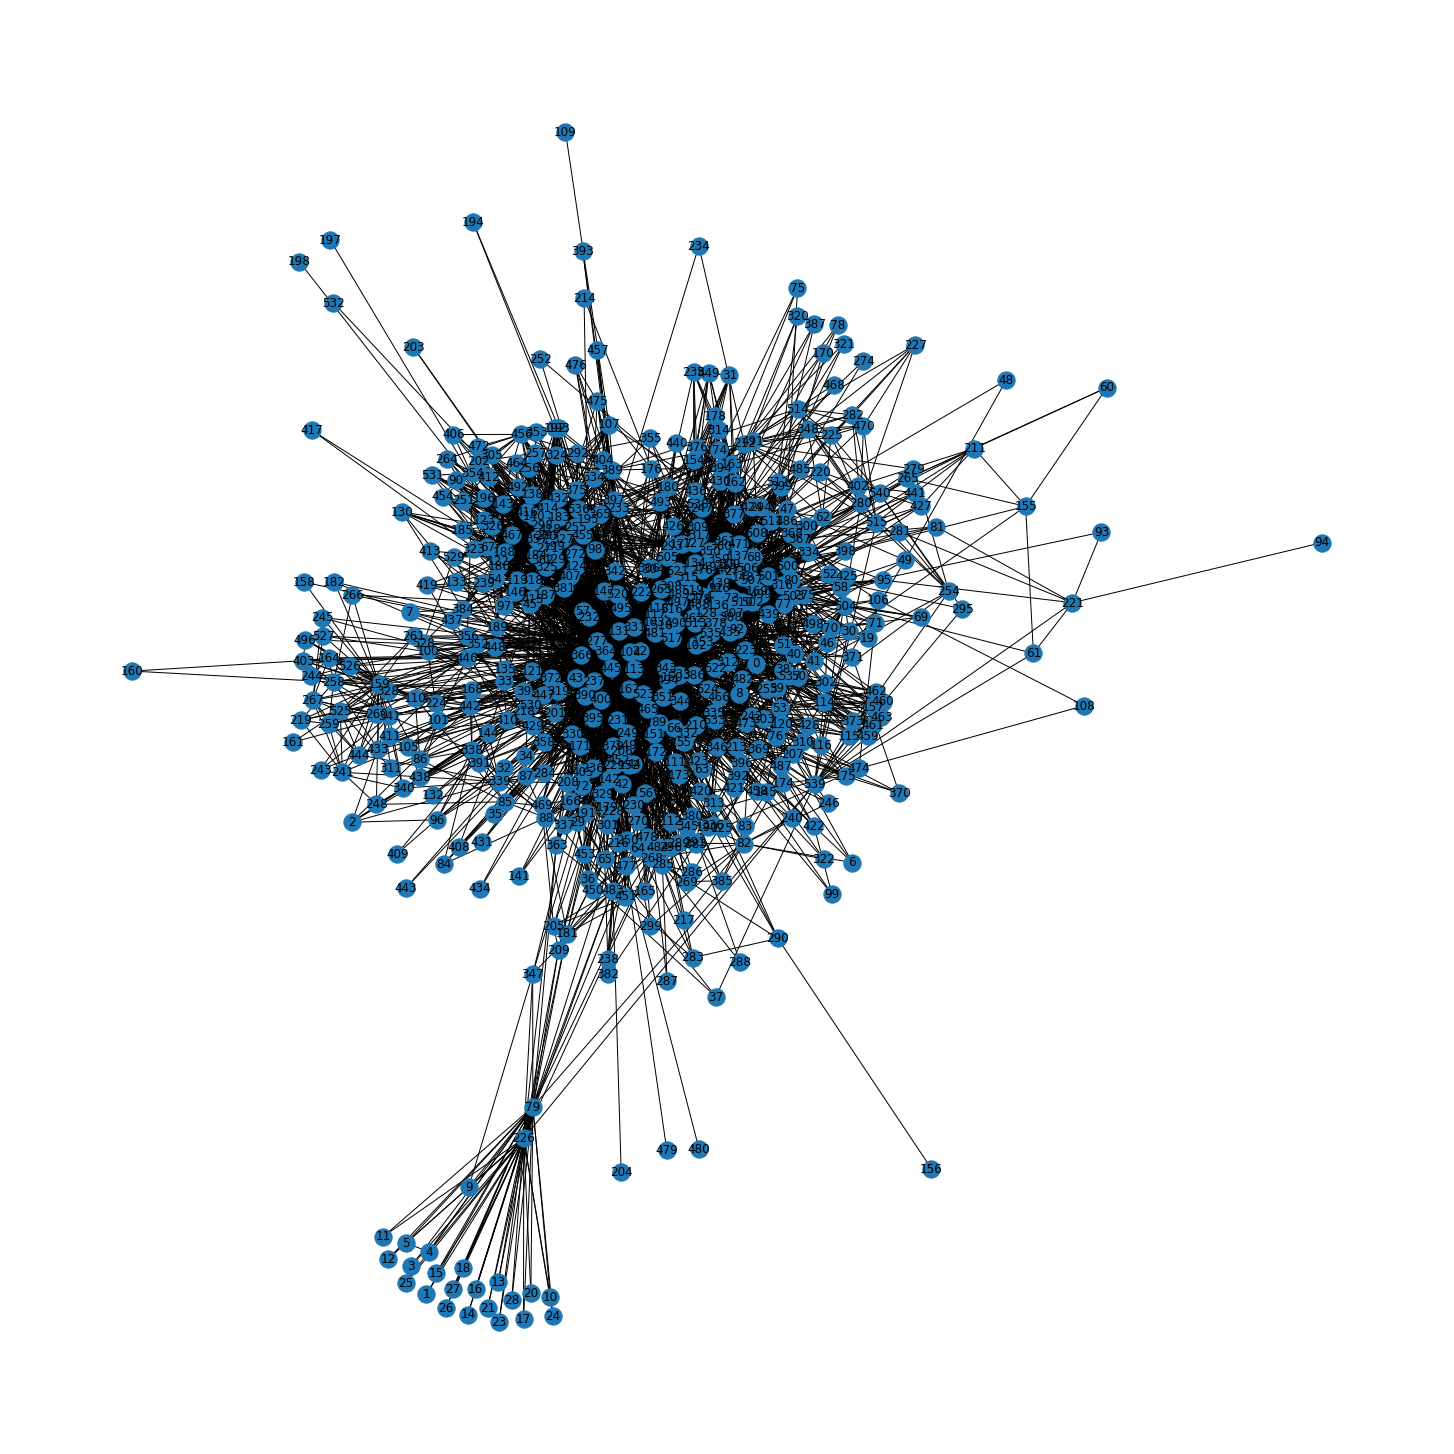

In [45]:
nx.draw(G, with_labels=True)

In [55]:
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=2, walk_length=10, num_walks=5, workers=4)
model = node2vec.fit(window=10, min_count=1)
model.wv.save_word2vec_format("embeding.emb")

Generating walks (CPU: 4): 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]


In [56]:
from sklearn.cluster import KMeans
import numpy as np

In [57]:
X = np.loadtxt("embeding.emb", skiprows=1)

In [59]:
Z = X[0:X.shape[0],1:X.shape[1]]

In [60]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)

In [62]:
result = pd.DataFrame(X)

In [63]:
result.head()

,0,1,2
0,104.0,0.898936,-0.798685
1,400.0,1.298092,-0.582307
2,481.0,0.773069,-0.887920
3,277.0,1.045906,-0.708574
4,79.0,-0.667200,-4.167814


In [64]:
result[3] = kmeans.labels_

In [66]:
result.head()

,0,1,2,3
0,104.0,0.898936,-0.798685,4
1,400.0,1.298092,-0.582307,3
2,481.0,0.773069,-0.887920,4
3,277.0,1.045906,-0.708574,3
4,79.0,-0.667200,-4.167814,2


In [67]:
result.columns = ['source label', 'a','b', 'cluster']

In [68]:
result = result.drop(['a','b'], axis=1)

In [71]:
result['source label'] = result['source label'].apply(lambda x: int(x))

In [72]:
result.head()

,source label,cluster
0,104,4
1,400,3
2,481,4
3,277,3
4,79,2


In [ ]:
pd.merge(df,result, on='sour')